In [55]:
import numpy as np
from time import time
from datagen.data_generate_ode import rk45
from systems.odes import lorenz
from utils.crossvalidation import CrossValidate
from utils.normalisation import normalise_arrays
from estimators.volt_funcs import Volterra
import matplotlib.pyplot as plt

In [54]:
# Create the Lorenz dataset
lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)
h = 0.005
t_span = (0, 40)
t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 8000 
washout = 1000
ntest = ndata - ntrain
    
# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1, 0].reshape((-1, 1)) 
training_teacher_orig = data[1:ntrain, 0].reshape((-1, 1))

# Normalise training arrays if necessary
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig], norm_type=None)
training_input, training_teacher = normalisation_output[0]

# Define the range of parameters for which you want to cross validate over
ld_coef_range = np.linspace(0.1, 0.9, 9).round(1)
tau_coef_range = np.linspace(0.1, 0.9, 9).round(1)
reg_range = np.logspace(-15, -1, 15)
param_ranges = [ld_coef_range, tau_coef_range, reg_range]

# Define the additional inputs taken in by the 
param_add = [washout]

# Instantiate CV, split dataset, crossvalidate in parallel
CV = CrossValidate(validation_parameters=[6000, 2000, 500], validation_type="rolling", 
                    task="PathContinue", norm_type="ScaleL2Shift", 
                    error_type="wasserstein1", log_interval=100)
cv_datasets = CV.split_data_to_folds(training_input, training_teacher)

In [56]:
data = cv_datasets[0][0][0]
freq, psd = periodogram(data[:, 0], window="hann", scaling="spectrum")

(0.0, 0.05)

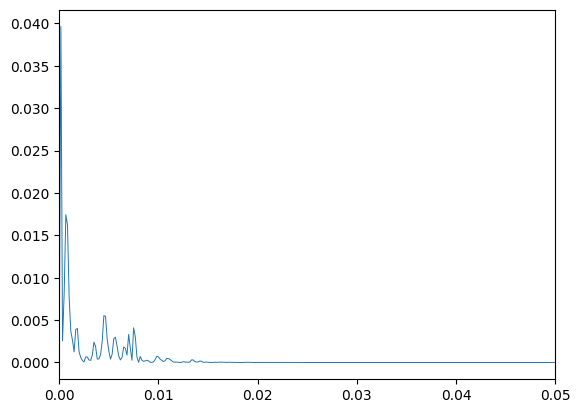

In [58]:
plt.plot(freq, psd, lw=0.7)
plt.xlim(0, 0.05)

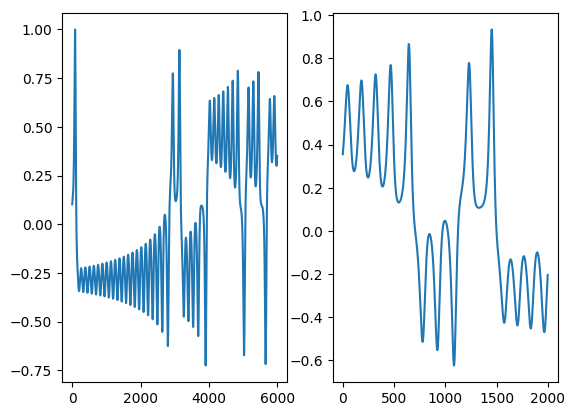

In [30]:
for i in range(len(cv_datasets)):
    train_in, validation_target = cv_datasets[i][0][0], cv_datasets[i][0][2]
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_in)
    axs[1].plot(validation_target)
    plt.show()
    plt.close()

In [50]:
from utils.errors import calculate_specdensloss
from scipy.signal import periodogram

train_in, train_teach, validation_target = cv_datasets[0][0][0], cv_datasets[0][0][1], cv_datasets[0][0][3]
shift, scale = cv_datasets[0][1], cv_datasets[0][2]

volt = Volterra(0.7, 0.5, 1e-06, 1000)
volt.Train(train_in, train_teach)
output = volt.PathContinue(train_teach[-1], validation_target.shape[0])

calculate_specdensloss(validation_target, output, shift, scale)


100.5773343961416

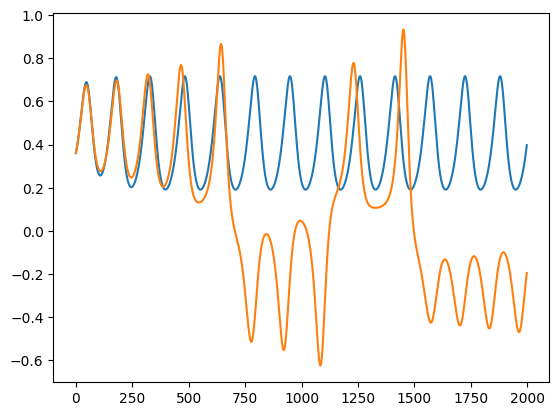

In [51]:
plt.plot(output)
plt.plot(validation_target)
plt.show()
plt.close()

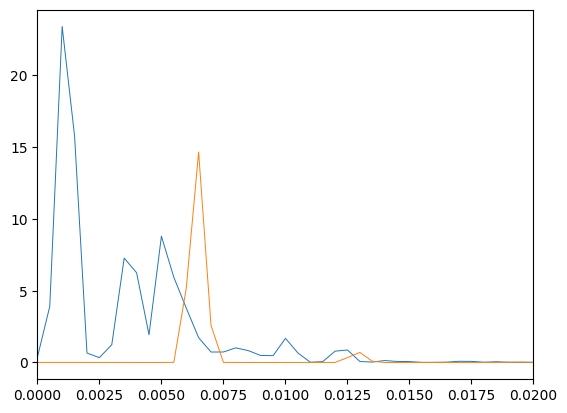

In [52]:

validation_target = validation_target * (1/scale) + shift
output = output * (1/scale) + shift

freq_true, psd_true = periodogram(validation_target[:, 0], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim(0, 0.02)
plt.show()
plt.close()